In [80]:
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize
import sympy as sm
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import minimize

from modelpro import malthus_economics 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analytical solution using Sumpy

To study the fertility model, we need some variables that define income, consumption, population and more.

In [81]:
#Defining variables and parameters
Y = sm.symbols('Y_t')
alpha = sm.symbols('alpha')
L = sm.symbols('L_t')
A = sm.symbols('A')
X = sm.symbols('X')
n = sm.symbols('n_t')
lambda_ = sm.symbols('lambda')
tau = sm.symbols('tau')
beta= sm.symbols('beta')
mu = sm.symbols('mu')
c = sm.symbols('c_t')
y = sm.symbols('y_t')
u= sm.symbols('u_t')
L1 = sm.symbols('L_t+1')
e = sm.symbols('eta')
L_ss = sm.symbols('L^*')

Writing up the utility

In [82]:
# Defining utility function
utility = beta*sm.ln(c)+(1-beta)*sm.ln(n)
utility

beta*log(c_t) + (1 - beta)*log(n_t)

The problem is to choose values for c and n such that the utility maximizes, given the following:

In [83]:
budgetconstraint = sm.Eq(c+lambda_*n,y*(1-tau))
budgetconstraint

Eq(c_t + lambda*n_t, y_t*(1 - tau))

Now solving with respect to c, which is the number of surviving children

In [84]:
c_solve = sm.solve(budgetconstraint, c)
c_substituted = c_solve[0]
c_substituted

-lambda*n_t - tau*y_t + y_t

Inserting this in the utility function to make it a function of n, we can maximize given the equation below

In [85]:
utility_substituted = utility.subs(c, c_substituted)
utility_substituted

beta*log(-lambda*n_t - tau*y_t + y_t) + (1 - beta)*log(n_t)

Taking the first order condition with respect to n to find the optimal level of births

In [86]:
first_order = sm.diff(utility_substituted, n)

first_order

-beta*lambda/(-lambda*n_t - tau*y_t + y_t) + (1 - beta)/n_t

The optimal number of births are then:

In [87]:
pop = sm.Eq(e, ((1-beta)/(lambda_))*(1-tau))
pop

Eq(eta, (1 - beta)*(1 - tau)/lambda)

In [88]:
n_solve = sm.solve(first_order, n)
n_solve[0]

y_t*(beta*tau - beta - tau + 1)/lambda

In [89]:
n_solvedd = sm.Eq(n, n_solve[0])
n_solvedd

Eq(n_t, y_t*(beta*tau - beta - tau + 1)/lambda)

In [90]:
sovledddd = n_solvedd.subs(e, (((1-beta)/(lambda_))*(1-tau)))
sovledddd

Eq(n_t, y_t*(beta*tau - beta - tau + 1)/lambda)

Going further, we look at the transition equation

In [91]:
transition = sm.Eq(n*L+(1-mu)*L, L1)
transition

Eq(L_t*n_t + L_t*(1 - mu), L_t+1)

Inserting per capita production equation into the fertility equation assuming:

In [92]:
income1 = sm.Eq(y, ((A*X)/L)**alpha)
income1

Eq(y_t, (A*X/L_t)**alpha)

In [93]:
transition_1 = transition.subs(n, n_solve[0])
transition_1

Eq(L_t*(1 - mu) + L_t*y_t*(beta*tau - beta - tau + 1)/lambda, L_t+1)

So, we get:

Using this term in the transition equation to get:

In [94]:
transition_2 = transition_1.subs(y, income1.rhs)
transition_2

Eq(L_t*(1 - mu) + L_t*(A*X/L_t)**alpha*(beta*tau - beta - tau + 1)/lambda, L_t+1)

Now we assume steady state levels $$L_{t+1}=L_t=L^*$$

In [95]:
L_steadystate = sm.Eq(L, L_ss)
L_steadystate

Eq(L_t, L^*)

In [96]:
transition_3 = transition_2.subs(L, L_steadystate.rhs)
transition_4 = transition_3.subs(L1, L_steadystate.rhs)
transition_4

Eq(L^**(1 - mu) + L^**(A*X/L^*)**alpha*(beta*tau - beta - tau + 1)/lambda, L^*)

In this paper the steady state is taken for the population density, X. To get the steady state given the population density, we have to make the following derivations:
$$(L^*)^{1-\alpha}(AX)^\alpha\eta=L^*\mu$$
$$\Leftrightarrow L^*=(AX)\left({\frac{\eta}{\mu}}\right)^{\frac{1}{\alpha}}$$
Now, it is possible to divide by the area of land, so we can get the population density:
$$\Leftrightarrow \frac{L^*}{X}=A\left({\frac{\eta}{\mu}}\right)^{\frac{1}{\alpha}}$$
From this point on, whenever we refer to the steady state of population, we look at the expression above.
However, we must not forget to substitute $\eta\equiv \frac{(1-\beta)(1-\tau)}{\lambda}$

Solving the steady state level for population:

In [97]:
L_steadystate1 = sm.Eq((A*(((1-beta)*(1-tau))/(lambda_*mu))**(1/alpha)), L_ss)
L_steadystate1

Eq(A*((1 - beta)*(1 - tau)/(lambda*mu))**(1/alpha), L^*)

We have the steady state for population and can therefore insert it in the income equation to get the steady state income level $$y^*=\left(\frac{AX}{L^*}\right)^\alpha$$


In [98]:
income2 = income1.subs(L, L_steadystate1.lhs)
income2

Eq(y_t, (X/((1 - beta)*(1 - tau)/(lambda*mu))**(1/alpha))**alpha)

When Python reads the parameter values, it will return False if the exponential is negative. Therefore, we use the sm.Abs function to take the absolute values of the expression.

In [99]:
income3 = sm.Abs((((A*X)/L_steadystate1.lhs)**alpha))
income3

Abs((X/((1 - beta)*(1 - tau)/(lambda*mu))**(1/alpha))**alpha)

For the parameters to be used in a computational way, they need to be converted using the lambdify option from sympy.

In [100]:
steadystate_income = sm.lambdify((X, alpha, beta,lambda_,mu,tau), income3)

Assuming the following parameter values:
- $X = 1$
- $\alpha = 0.5$
- $\beta = 0.5$
- $\lambda = 1$
- $\mu = 0.01$
- $\tau = 0.4$

In [101]:
steadystate_income(1, 0.5, 0.5, 1, 0.01, 0.4)

0.03333333333333333

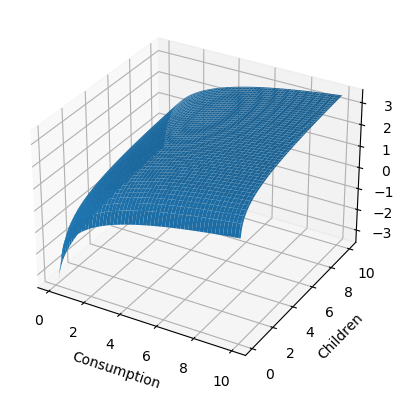

In [102]:
# Define the range of values for consumption and leisure
c_range = np.linspace(0.1, 10, 100)
n_range = np.linspace(0.1, 10, 100)

# Create a meshgrid of the range of values
c, n = np.meshgrid(c_range, n_range)

# Define the utility function
beta = 0.5
u = np.log(c) + beta * np.log(n)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(c, n, u)
ax.set_xlabel('Consumption')
ax.set_ylabel('Children')
ax.set_zlabel('Utility')
plt.show()

# Numerical analysis
In this last half of the project we use another approach to reach the steady state level and determining the levels of the respective variables that the model consists of.

Steady state population size: 89345.92851543528
Optimal number of children: 0.010035644099234346
Steady state income: 0.03345512190608986


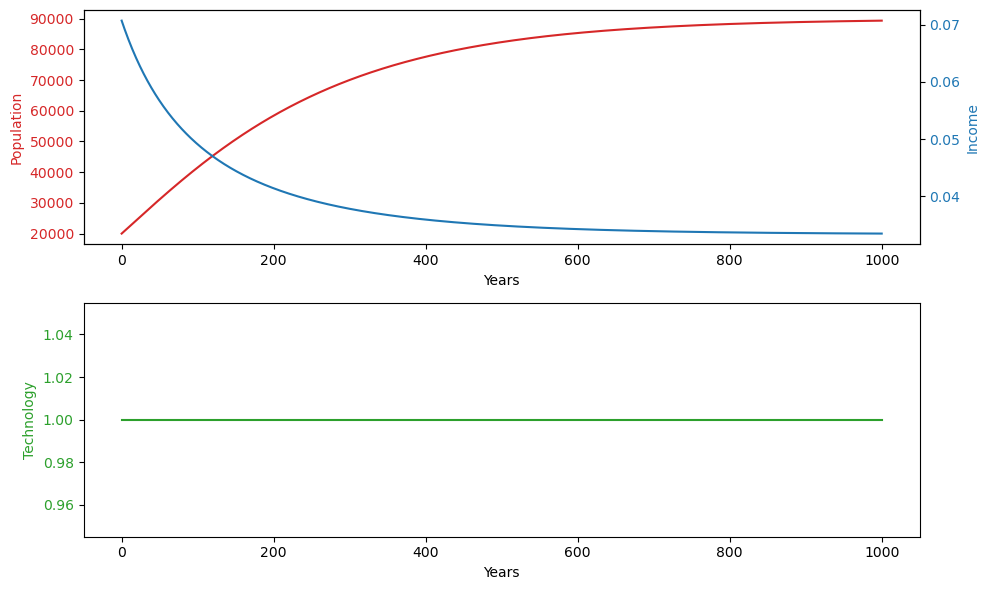

In [108]:
# Solve the model using the MalthusModel class
model = malthus_economics()
model.steady_state()


Below we look at the economy with a shock to the technological level

Steady state population size: 178795.57944242214
Optimal number of children: 0.01003271997879523
Steady state income: 0.033445416550571185


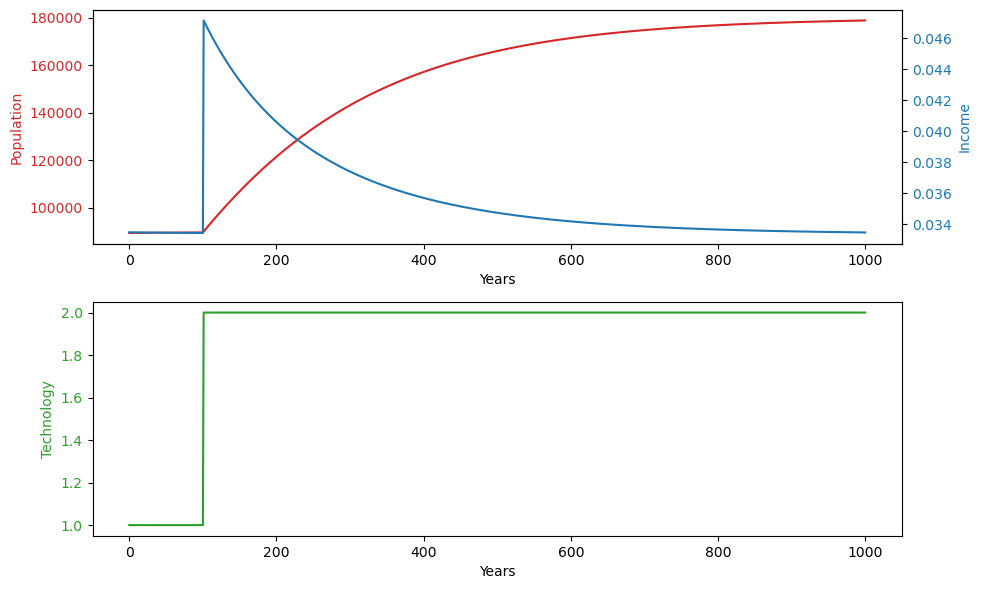

In [109]:
#Define the initial population in the steady state
model.L = model.L
#Use the model where a technology shock is introduced in period 100
try:
    steady_state_population, optimal_num_children, steady_state_income = model.steady_state1()

except:
    pass

Steady state population size: 97177.26181952293
Optimal number of children: 0.010115966523739774
Steady state income: 0.033723396564676315


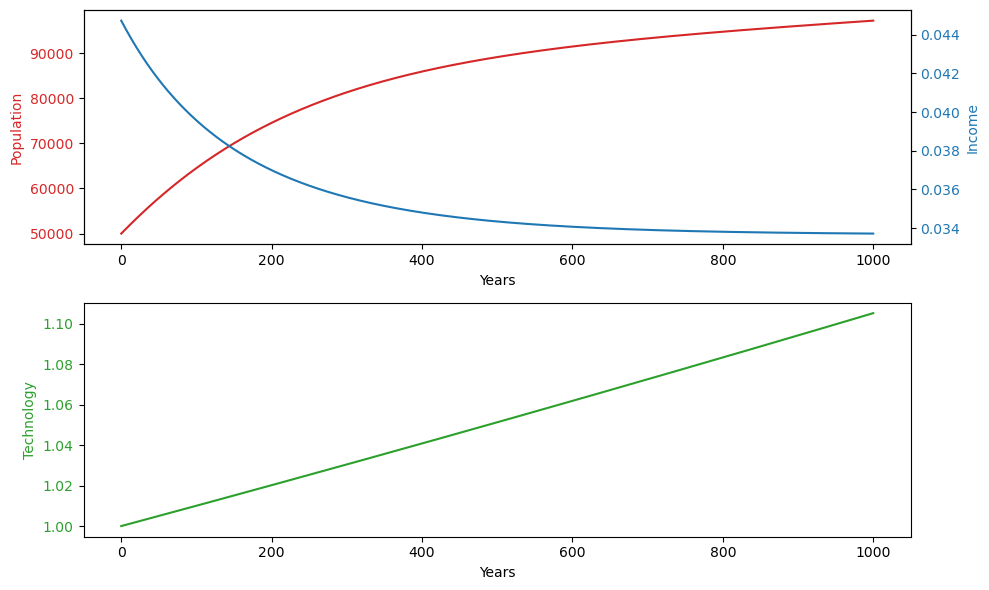

In [110]:
#Changing population to 50.0000 and making technological level equal 1 with an increase of 0.0001 each year
model.L = 50000
model.A = 1
model.g=0.0001

try:
    steady_state_population, optimal_num_children, steady_state_income = model.steady_state()

except:
    pass